## Clusterização dos Clientes

#### **Objetivo principal:** divisão dos clientes em diferentes grupos de acordo com características principais de cada um.

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Para evitar os vários warnings nos modelos KMeans (precisa ser executado antes de qualquer biblioteca)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    PowerTransformer, StandardScaler, MinMaxScaler,
)

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from src.graficos import (
    grafico_elbow_silhouette, 
    plot_columns_percent_by_cluster, plot_columns_percent_hue_cluster
)
sns.set_theme(palette="bright")

RANDOM_STATE = 42

In [3]:
df = pd.read_csv("../dados/customers_data_cleaned.csv")
df.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,YearsSinceEnrolled,Age,AgeGroup,MntTotal,MntRegularProducts,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,1,57,46-60,1617,1529,0,0,0,0,22
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,60,46-60,27,21,2,1,0,0,4
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,0,49,46-60,776,734,0,0,0,0,20
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,0,30,18-30,53,48,1,1,0,0,6
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,0,33,31-45,422,407,1,1,0,0,14


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   object 
 1   Marital_Status       2212 non-null   object 
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   MntWines             2212 non-null   int64  
 7   MntFruits            2212 non-null   int64  
 8   MntMeatProducts      2212 non-null   int64  
 9   MntFishProducts      2212 non-null   int64  
 10  MntSweetProducts     2212 non-null   int64  
 11  MntGoldProds         2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurchases    2212 non-null   i

#### Analisando a distribuição dos dados de cada feature

In [5]:
numerical_features = df.select_dtypes(include="number").columns
len(numerical_features)

32

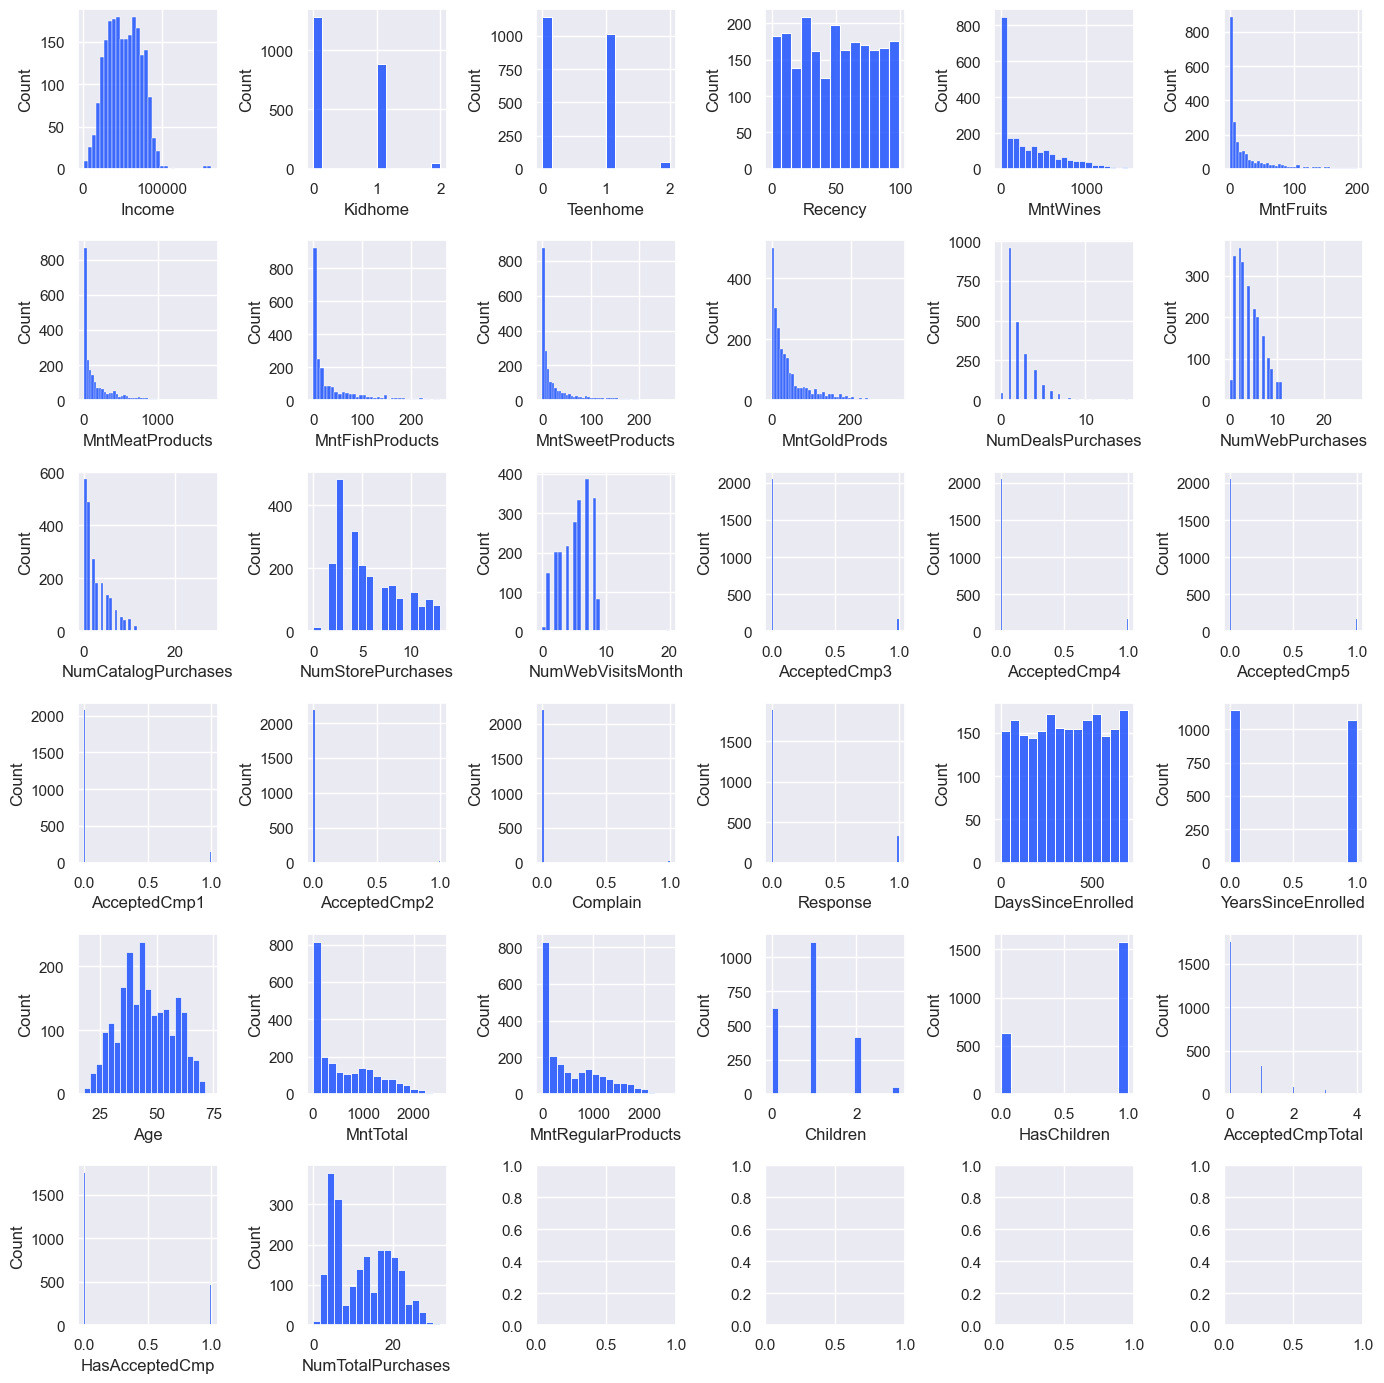

In [6]:
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(14, 14), tight_layout=True)

for ax, feature in zip(axs.flatten(), numerical_features):
    sns.histplot(x=feature, ax=ax, data=df)

plt.show()

#### Separando as colunas pelo tipo

In [7]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'DaysSinceEnrolled', 'YearsSinceEnrolled',
       'Age', 'AgeGroup', 'MntTotal', 'MntRegularProducts', 'Children',
       'HasChildren', 'AcceptedCmpTotal', 'HasAcceptedCmp',
       'NumTotalPurchases'],
      dtype='object')

In [8]:
df.shape

(2212, 35)

**Padrões de separação das features:**

- MinMaxScaler: dados com distribuição uniforme
- StandardScaler: dados que seguem distribuição normal
- One Hot Enconder: features categóricas, mesmo que os dados sejam numéricos, mas com pouco resultados inteiros (0, 1, 2 ...)
- PowerTransform: dados que não seguem distribuições normais, pode ser usado para dados assimétricos (onde há uma distribuição dos dados maior para menores valores)

In [9]:
# Colunas categóricas
colunas_one_hot = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Response",
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
]

# onde temos uma distribuição uniforme dos dados e queremos padronizar a distruibuição dos dados (entre 0 e 1)
colunas_standard_scaler = [
    "Income",
    "Age",
]

# Quando a distribuição não é normal, e queremos normalizar
colunas_power_transform = df.columns[
   df.columns.str.startswith("Mnt") | df.columns.str.startswith("Num")
].tolist()

# onde já temos uma distribuição uniforme dos dados e queremos padronizar a distribuição dos dados (entre 0 e 1)
colunas_minmax = [
    col for col in df.columns if col not in colunas_one_hot + colunas_standard_scaler + colunas_power_transform
]

#### Definir Preprocessamento

In [10]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("one-hot", OneHotEncoder(), colunas_one_hot),
        ("standard", StandardScaler(), colunas_standard_scaler),
        ("minmax", MinMaxScaler(), colunas_minmax),
        ("power", PowerTransformer(), colunas_power_transform),
    ], remainder='passthrough'
)

preprocessamento

ColumnTransformer(remainder='passthrough',
                  transformers=[('one-hot', OneHotEncoder(),
                                 ['Education', 'Marital_Status', 'AgeGroup',
                                  'HasChildren', 'HasAcceptedCmp',
                                  'AcceptedCmp1', 'AcceptedCmp2',
                                  'AcceptedCmp3', 'AcceptedCmp4',
                                  'AcceptedCmp5', 'Complain', 'Response',
                                  'Kidhome', 'Teenhome', 'YearsSinceEnrolled',
                                  'Children', 'AcceptedCmpTotal']),
                                ('standard', StandardScal...
                                 ['Income', 'Age']),
                                ('minmax', MinMaxScaler(),
                                 ['Recency', 'DaysSinceEnrolled']),
                                ('power', PowerTransformer(),
                                 ['MntWines', 'MntFruits', 'MntMeatProducts',
                                  'MntFishProducts', 'MntSweetProducts',
                                  'MntGoldProds', 'NumDealsPurchases',
                                  'NumWebPurchases', 'NumCatalogPurchases',
                                  'NumStorePurchases', 'NumWebVisitsMonth',
                                  'MntTotal', 'MntRegularProducts',
                                  'NumTotalPurchases'])])

#### Analisando a transformação do dataframe após preprocessamento

In [11]:
df_preprocessado = pd.DataFrame(
    preprocessamento.fit_transform(df),
    columns=preprocessamento.get_feature_names_out()
)

df_preprocessado.head()

,one-hot__Education_2n Cycle,one-hot__Education_Basic,one-hot__Education_Graduation,one-hot__Education_Master,one-hot__Education_PhD,one-hot__Marital_Status_Partner,one-hot__Marital_Status_Single,one-hot__AgeGroup_18-30,one-hot__AgeGroup_31-45,one-hot__AgeGroup_46-60,...,power__MntSweetProducts,power__MntGoldProds,power__NumDealsPurchases,power__NumWebPurchases,power__NumCatalogPurchases,power__NumStorePurchases,power__NumWebVisitsMonth,power__MntTotal,power__MntRegularProducts,power__NumTotalPurchases
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.388725,1.091272,0.746207,1.334188,1.725656,-0.421872,0.702496,1.314196,1.309163,1.219402
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.973382,-0.940642,0.158507,-1.363525,-0.379079,-1.430172,-0.102583,-1.443510,-1.450573,-1.307114
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.551061,0.447232,-0.824617,1.334188,0.154062,1.240619,-0.518935,0.657956,0.687288,1.022712
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.521026,-1.045517,0.158507,-0.716552,-1.341368,-0.421872,0.304033,-1.120416,-1.063757,-0.872312
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.698205,-0.344896,1.445241,0.522764,0.519605,0.271375,-0.102583,0.175236,0.238821,0.353342


In [12]:
df_preprocessado.shape

(2212, 64)

In [13]:
#df_preprocessado.to_csv("../dados/customers_data_cleaned_preprocessado.csv")

### Estudo para determinar número de componentes da PCA

In [14]:
df_estudo_pca = df.copy()

In [15]:
estudo_pca = Pipeline([
    ('preprocessamento', preprocessamento),
    ('pca', PCA())
])

estudo_pca

estudo_pca.fit(df_estudo_pca)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'HasChildren',
                                                   'HasAcceptedCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Response', 'Kidhome',
                                                   'Teenhome',
                                                   'YearsSinceEnrolled',
                                                   'Children',
                                                   'Accepted...
                                                 ('minmax', MinMaxScaler(),
                                                  ['Recency',
                                                   'DaysSinceEnrolled']),
                                                 ('power', PowerTransformer(),
                                                  ['MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal',
                                                   'MntRegularProducts',
                                                   'NumTotalPurchases'])])),
                ('pca', PCA())])

In [16]:
estudo_pca['pca'].components_

array([[-2.36580522e-03, -7.90633607e-03,  8.62966415e-03, ...,
         3.06831001e-01,  3.05845079e-01,  2.95466359e-01],
       [-1.47682227e-02, -1.08999223e-02, -1.78516088e-02, ...,
         6.13235929e-02,  6.39026598e-02,  1.44967709e-01],
       [-3.58686319e-02, -2.00724738e-02, -7.77587055e-02, ...,
        -1.47945462e-03,  1.78626570e-02, -4.20786266e-03],
       ...,
       [ 2.68540611e-08,  2.68540627e-08,  2.68540614e-08, ...,
         1.14630527e-14, -1.48492330e-14,  2.49800181e-15],
       [ 0.00000000e+00, -8.04911693e-16,  8.88474887e-16, ...,
         1.03944631e-14, -8.95117314e-15, -6.05765438e-15],
       [ 1.20167233e-08,  1.20167242e-08,  1.20167219e-08, ...,
        -3.92602617e-14,  4.50334214e-14,  5.75928194e-15]],
      shape=(64, 64))

In [17]:
estudo_pca['pca'].explained_variance_ratio_

array([4.62973355e-01, 9.79125597e-02, 6.60456445e-02, 4.40311262e-02,
       3.71768562e-02, 2.53834327e-02, 2.24181438e-02, 2.14446031e-02,
       2.04989368e-02, 1.90150350e-02, 1.64493262e-02, 1.47575978e-02,
       1.43469444e-02, 1.41013037e-02, 1.31863614e-02, 1.23734817e-02,
       1.11795577e-02, 1.00074911e-02, 8.59673455e-03, 8.35266268e-03,
       7.67274918e-03, 7.03102015e-03, 6.44111588e-03, 5.19437485e-03,
       4.30788089e-03, 4.08515119e-03, 3.54952982e-03, 3.41976386e-03,
       3.12167938e-03, 2.40798751e-03, 2.33714279e-03, 1.68039312e-03,
       1.37939863e-03, 1.30007325e-03, 1.06222806e-03, 1.01953418e-03,
       8.55992295e-04, 8.09368784e-04, 7.45002185e-04, 6.38215791e-04,
       3.73416059e-04, 2.79845680e-04, 3.69826281e-05, 1.77539597e-17,
       9.05635945e-18, 7.28118035e-18, 6.37039877e-18, 4.43305975e-18,
       2.94083080e-18, 1.32952253e-18, 1.04712629e-18, 9.00009612e-19,
       4.73596970e-19, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [18]:
np.cumsum(estudo_pca['pca'].explained_variance_ratio_)

array([0.46297335, 0.56088591, 0.62693156, 0.67096269, 0.70813954,
       0.73352297, 0.75594112, 0.77738572, 0.79788466, 0.81689969,
       0.83334902, 0.84810662, 0.86245356, 0.87655486, 0.88974123,
       0.90211471, 0.91329427, 0.92330176, 0.93189849, 0.94025115,
       0.9479239 , 0.95495492, 0.96139604, 0.96659041, 0.97089829,
       0.97498345, 0.97853298, 0.98195274, 0.98507442, 0.98748241,
       0.98981955, 0.99149994, 0.99287934, 0.99417941, 0.99524164,
       0.99626118, 0.99711717, 0.99792654, 0.99867154, 0.99930976,
       0.99968317, 0.99996302, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

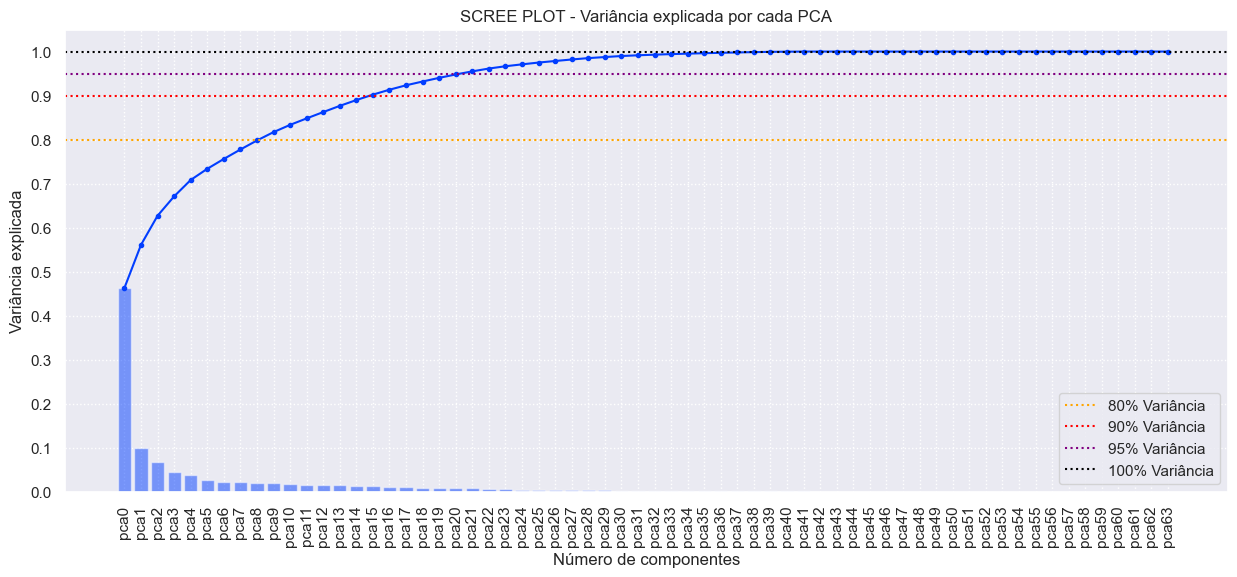

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(estudo_pca['pca'].get_feature_names_out(),
        estudo_pca['pca'].explained_variance_ratio_,
        alpha=0.5)

ax.plot(np.cumsum(estudo_pca['pca'].explained_variance_ratio_), marker='.')

ax.axhline(y=0.8, color='orange', linestyle=":", label="80% Variância")
ax.axhline(y=0.9, color='red', linestyle=":", label="90% Variância")
ax.axhline(y=0.95, color='purple', linestyle=":", label="95% Variância")
ax.axhline(y=1, color='black', linestyle=":", label="100% Variância")

ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.tick_params(axis='x', rotation=90)
ax.grid(linestyle=':')
ax.legend()
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Variância explicada')
ax.set_title('SCREE PLOT - Variância explicada por cada PCA')

plt.show()

**Conclusão:** Podemos usar PCA = 8 para explicar 80% da variância dos dados.

### Estudo para determinar número de Clusters (K)

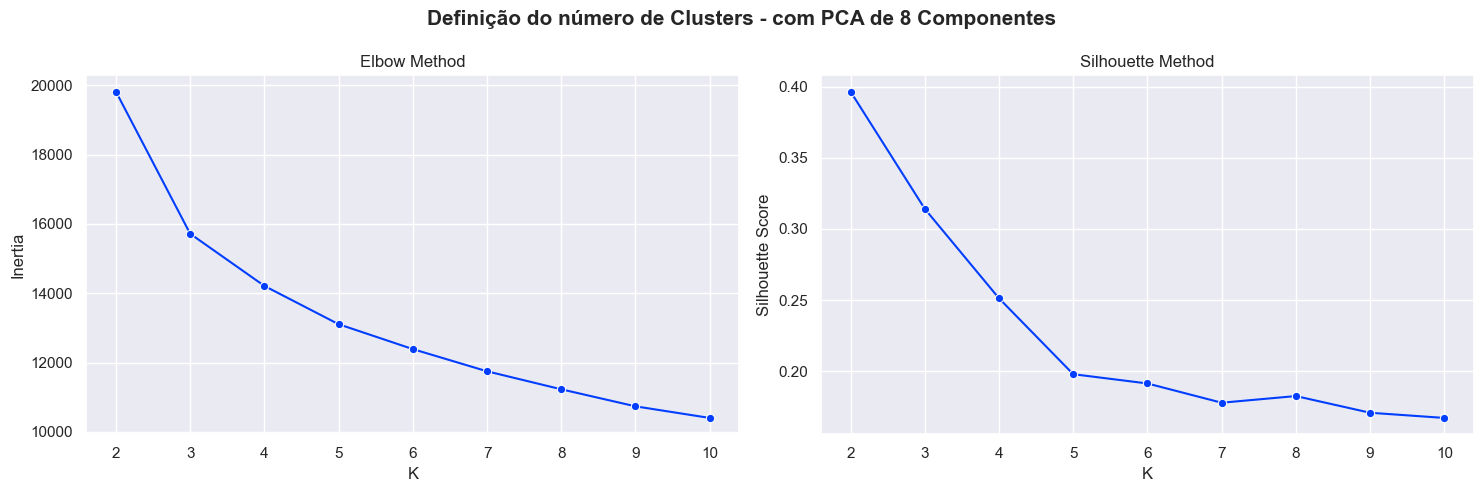

In [20]:
# GRÁFICO CONSIDERANDO O PCA DENTRO DA ANÁLISE DO ELBOW METHOD E SILHOUETTE SCORE

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), tight_layout=True)

elbow = {}
silhouette = []

X = df

k_range = range(2,11)

for numero in k_range:
    kmeans = Pipeline([
        ('preprocessamento', preprocessamento),
        ('pca', PCA(n_components=8, random_state=RANDOM_STATE)),
        ('kmeans', KMeans(n_clusters=numero, n_init= 10, random_state=RANDOM_STATE))   # n_init: é o número de vezes que o k-means é iniciado com diferentes centroides iniciais
    ])
    
    kmeans.fit(X)         

    elbow[numero] = kmeans['kmeans'].inertia_      # inertia_ : soma da distância quadrada de cada ponto para o centroide de seu cluster
    labels = kmeans['kmeans'].labels_              # labels_: nome de cada cluster
    
    # ETAPA PARA CORREÇÃO DO GRÁFICO ACIMA, GERAR O X_TRANFORMADO ABAIXO
    X_transformado_preprocessamento = kmeans.named_steps['preprocessamento'].transform(X)
    X_transformado_pca = kmeans.named_steps['pca'].transform(X_transformado_preprocessamento)

    silhouette.append(silhouette_score(X_transformado_pca, labels))       
    # silhouete_score: dentro de cada cluster ele calcula a distância média de cada ponto, e compara com a distânia do ponto pro cluster mais próximo que ele não pertence
    # silhouete_score: varia de -1 a 1, quanto maior melhor, mais bem dividido estão os clusters. Valor igual a 0 quer dizer que o ponto está na distancia igual entre o centro de 2 cluster

# OBS: lineplot precisa dos valores em formato de lista
sns.lineplot( x = list(elbow.keys()), y = list(elbow.values()), ax=ax[0], marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('K')
ax[0].set_ylabel('Inertia')

sns.lineplot( x = list(k_range), y = silhouette, ax=ax[1], marker='o')
ax[1].set_title('Silhouette Method')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Silhouette Score')

fig.suptitle('Definição do número de Clusters - com PCA de 8 Componentes', fontsize=15, fontweight='bold') 

plt.show()

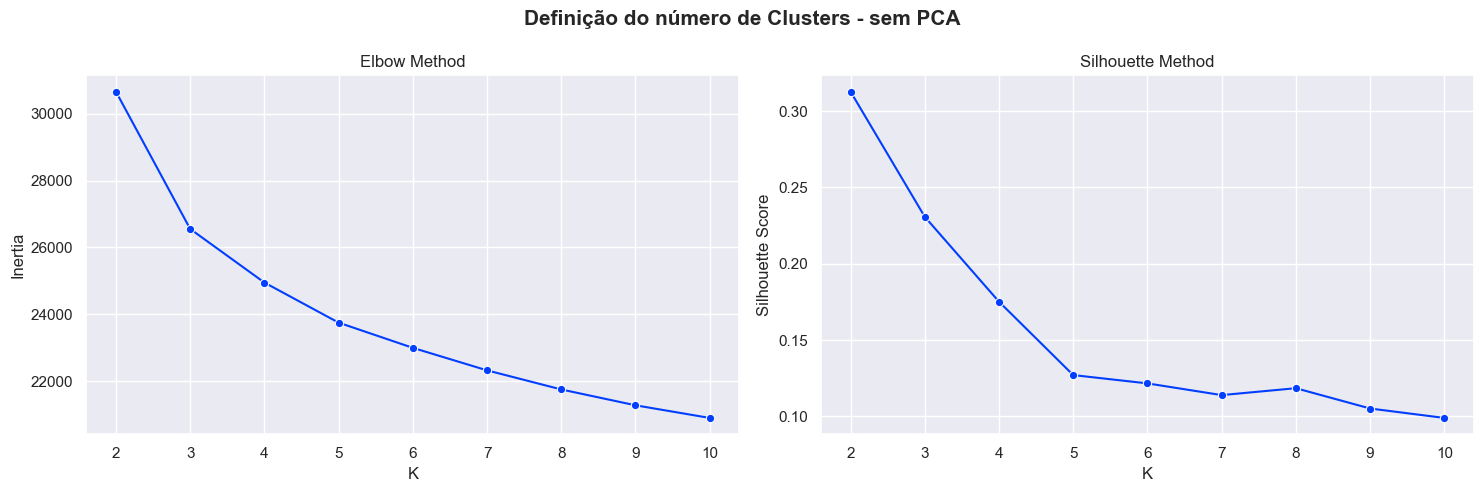

In [21]:
# GRÁFICO SEM CONSIDERAR O PCA DENTRO DA ANÁLISE DO ELBOW METHOD E SILHOUETTE SCORE

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), tight_layout=True)

elbow = {}
silhouette = []

X = df

k_range = range(2,11)

for numero in k_range:
    kmeans = Pipeline([
        ('preprocessamento', preprocessamento),
        #('pca', PCA(n_components=8, random_state=RANDOM_STATE)),
        ('kmeans', KMeans(n_clusters=numero, n_init= 10, random_state=RANDOM_STATE))   # n_init: é o número de vezes que o k-means é iniciado com diferentes centroides iniciais
    ])
    
    kmeans.fit(X)         

    elbow[numero] = kmeans['kmeans'].inertia_      # inertia_ : soma da distância quadrada de cada ponto para o centroide de seu cluster
    labels = kmeans['kmeans'].labels_              # labels_: nome de cada cluster
    
    # ETAPA PARA CORREÇÃO DO GRÁFICO ACIMA, GERAR O X_TRANFORMADO ABAIXO
    X_transformado_preprocessamento = kmeans.named_steps['preprocessamento'].transform(X)
    #X_transformado_pca = kmeans.named_steps['pca'].transform(X_transformado_preprocessamento)

    silhouette.append(silhouette_score(X_transformado_preprocessamento, labels))       
    # silhouete_score: dentro de cada cluster ele calcula a distância média de cada ponto, e compara com a distânia do ponto pro cluster mais próximo que ele não pertence
    # silhouete_score: varia de -1 a 1, quanto maior melhor, mais bem dividido estão os clusters. Valor igual a 0 quer dizer que o ponto está na distancia igual entre o centro de 2 cluster

# OBS: lineplot precisa dos valores em formato de lista
sns.lineplot( x = list(elbow.keys()), y = list(elbow.values()), ax=ax[0], marker='o')
ax[0].set_title('Elbow Method')
ax[0].set_xlabel('K')
ax[0].set_ylabel('Inertia')

sns.lineplot( x = list(k_range), y = silhouette, ax=ax[1], marker='o')
ax[1].set_title('Silhouette Method')
ax[1].set_xlabel('K')
ax[1].set_ylabel('Silhouette Score')

fig.suptitle('Definição do número de Clusters - sem PCA', fontsize=15, fontweight='bold')

plt.show()

**Conclusão:** O Número de clusters mais indicado seria 2 ou 3.

- Vamos usar K=3

#### Definir o modelo KMeans com o número de Clusters e do PCA definido acima

In [22]:
pipeline = Pipeline([
    ('preprocessamento', preprocessamento),
    ('pca', PCA(n_components=8, random_state=RANDOM_STATE)),
    ('clustering', KMeans(n_clusters=3, n_init= 10, random_state=RANDOM_STATE))
])  

#OBS: n_init: é o número de vezes que o k-means é iniciado com diferentes centroides iniciais

In [23]:
pipeline.fit(df)

Pipeline(steps=[('preprocessamento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one-hot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'HasChildren',
                                                   'HasAcceptedCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Response', 'Kidhome',
                                                   'Teenhome',
                                                   'YearsSinceEnrolled',
                                                   'Children',
                                                   'Accepted...
                                                  ['MntWines', 'MntFruits',
                                                   'MntMeatProducts',
                                                   'MntFishProducts',
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal',
                                                   'MntRegularProducts',
                                                   'NumTotalPurchases'])])),
                ('pca', PCA(n_components=8, random_state=42)),
                ('clustering',
                 KMeans(n_clusters=3, n_init=10, random_state=42))])

#### Verificando parametros do modelo

In [24]:
pipeline.named_steps

{'preprocessamento': ColumnTransformer(remainder='passthrough',
                   transformers=[('one-hot', OneHotEncoder(),
                                  ['Education', 'Marital_Status', 'AgeGroup',
                                   'HasChildren', 'HasAcceptedCmp',
                                   'AcceptedCmp1', 'AcceptedCmp2',
                                   'AcceptedCmp3', 'AcceptedCmp4',
                                   'AcceptedCmp5', 'Complain', 'Response',
                                   'Kidhome', 'Teenhome', 'YearsSinceEnrolled',
                                   'Children', 'AcceptedCmpTotal']),
                                 ('standard', StandardScal...
                                  ['Income', 'Age']),
                                 ('minmax', MinMaxScaler(),
                                  ['Recency', 'DaysSinceEnrolled']),
                                 ('power', PowerTransformer(),
                                  ['MntWines', 'MntFruits', 'M

In [25]:
pipeline.get_feature_names_out()

array(['kmeans0', 'kmeans1', 'kmeans2'], dtype=object)

In [26]:
pipeline['clustering'].labels_

array([2, 1, 2, ..., 2, 0, 1], shape=(2212,), dtype=int32)

#### Adicionando os clusters no dataframe original

In [27]:
df_clustered = df.copy()
df_clustered['cluster'] = pipeline['clustering'].labels_
df_clustered

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProducts,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,NumTotalPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,2
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,2
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,Graduation,Partner,61223.0,0,1,46,709,43,182,42,...,47,46-60,1341,1094,1,1,0,0,16,0
2208,PhD,Partner,64014.0,2,1,56,406,0,30,0,...,68,61+,444,436,3,1,1,1,15,0
2209,Graduation,Single,56981.0,0,0,91,908,48,217,32,...,33,31-45,1241,1217,0,0,1,1,18,2
2210,Master,Partner,69245.0,0,1,8,428,30,214,80,...,58,46-60,843,782,1,1,0,0,21,0


In [28]:
df_clustered['cluster'].value_counts().sort_index()

cluster
0    742
1    899
2    571
Name: count, dtype: int64

### Análises Gráficas para identificar diferença dos Clusters

In [29]:
df_clustered.groupby('cluster').describe().T

cluster                             0             1             2
Income            count    742.000000    899.000000    571.000000
                  mean   56357.268194  33279.741935  75652.028021
                  std    12379.332632  14234.732250  11887.571434
                  min     2447.000000   1730.000000  32632.000000
                  25%    48504.250000  24457.000000  69757.000000
...                               ...           ...           ...
NumTotalPurchases min        7.000000      0.000000      9.000000
                  25%       12.000000      4.000000     16.000000
                  50%       16.000000      5.000000     19.000000
                  75%       20.000000      6.000000     22.000000
                  max       32.000000     25.000000     32.000000

[256 rows x 3 columns]

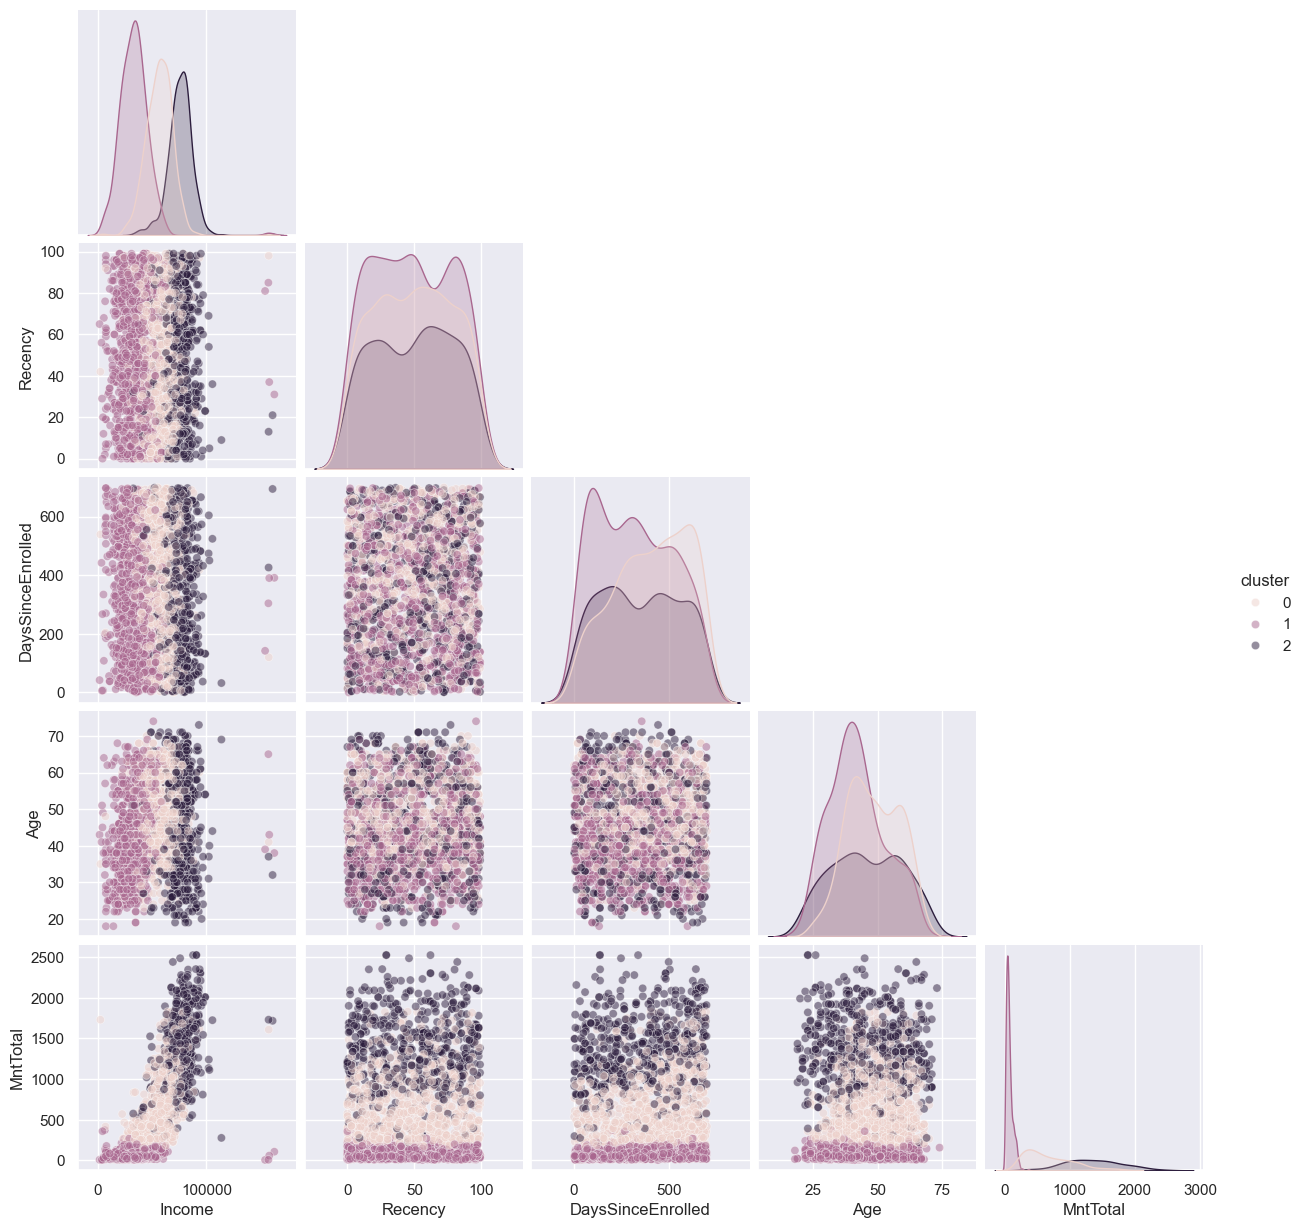

In [30]:
from src.graficos import pairplot

analise_colunas = ['Income', 'Recency', 'DaysSinceEnrolled', 'Age', 'MntTotal']

pairplot(df_clustered, columns=analise_colunas, hue_column="cluster")

[]

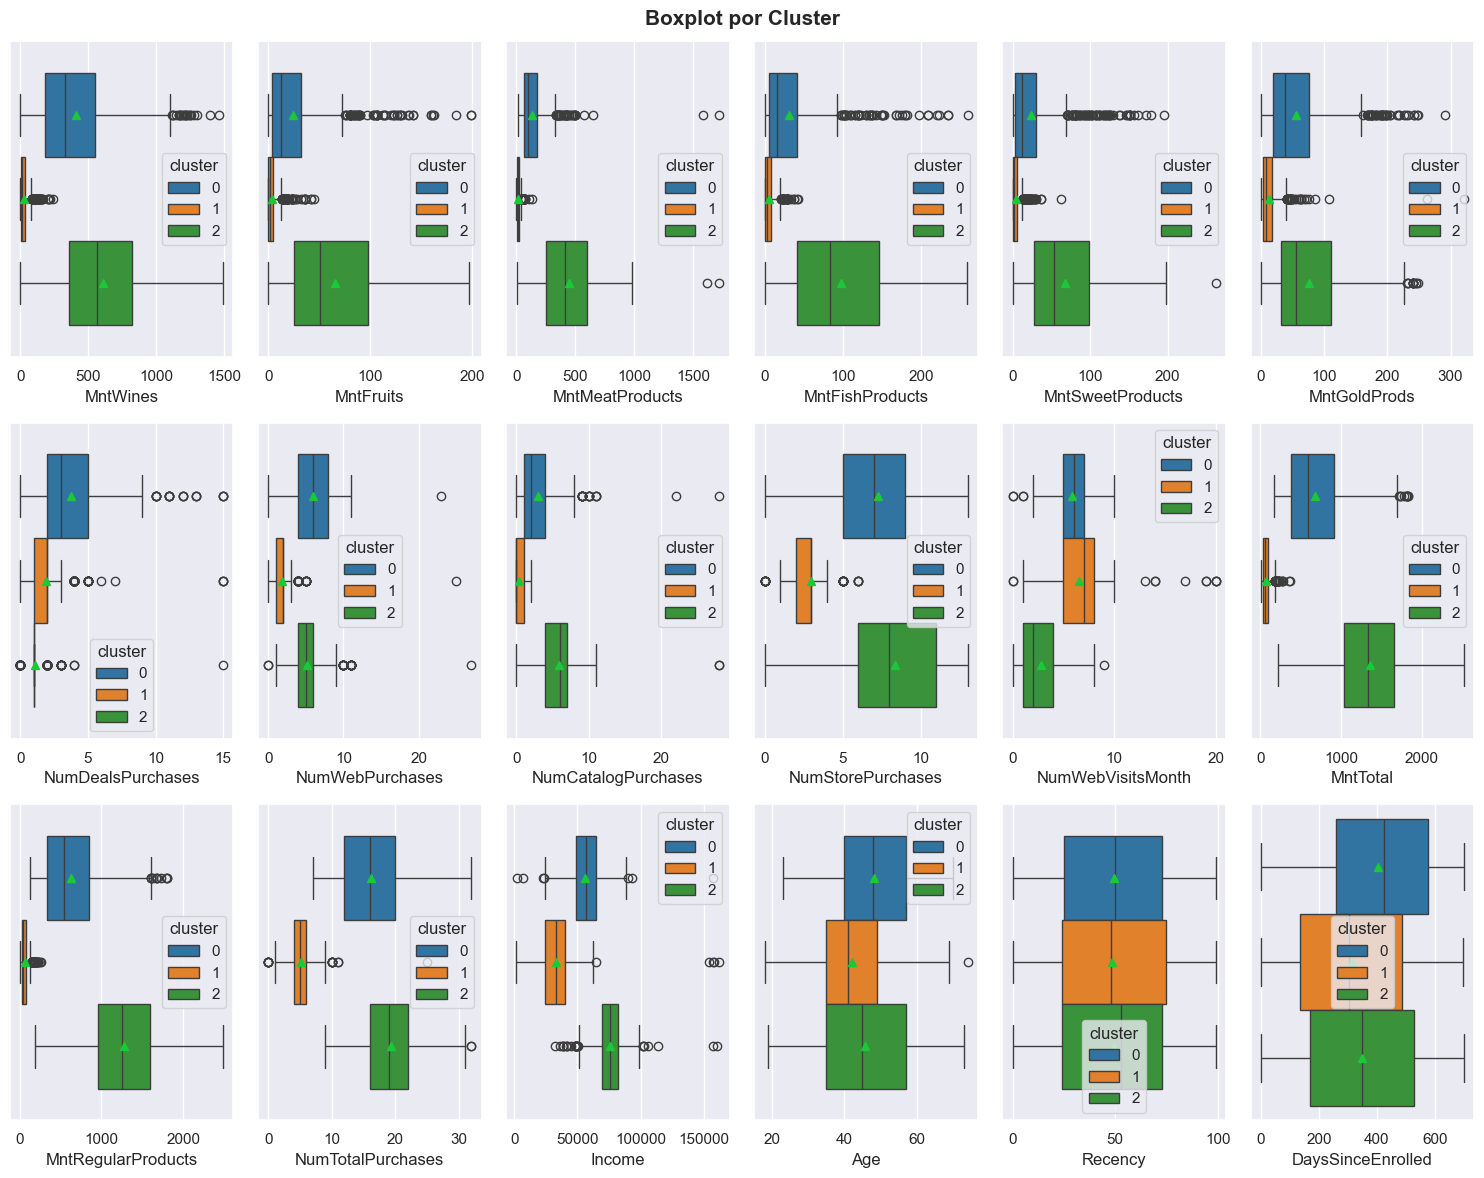

In [31]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(15,12))

#for ax, coluna in zip(axs.flatten(), df_clustered.select_dtypes('number')):
for ax, coluna in zip(axs.flatten(), df_clustered[colunas_power_transform + colunas_standard_scaler + colunas_minmax]):
    sns.boxplot(
        data=df_clustered, 
        x=coluna, 
        ax=ax, 
        showmeans=True, 
        hue='cluster',
        palette='tab10'
    )

fig.suptitle('Boxplot por Cluster', fontsize=15, fontweight='bold',)
plt.tight_layout()

plt.plot()  

[]

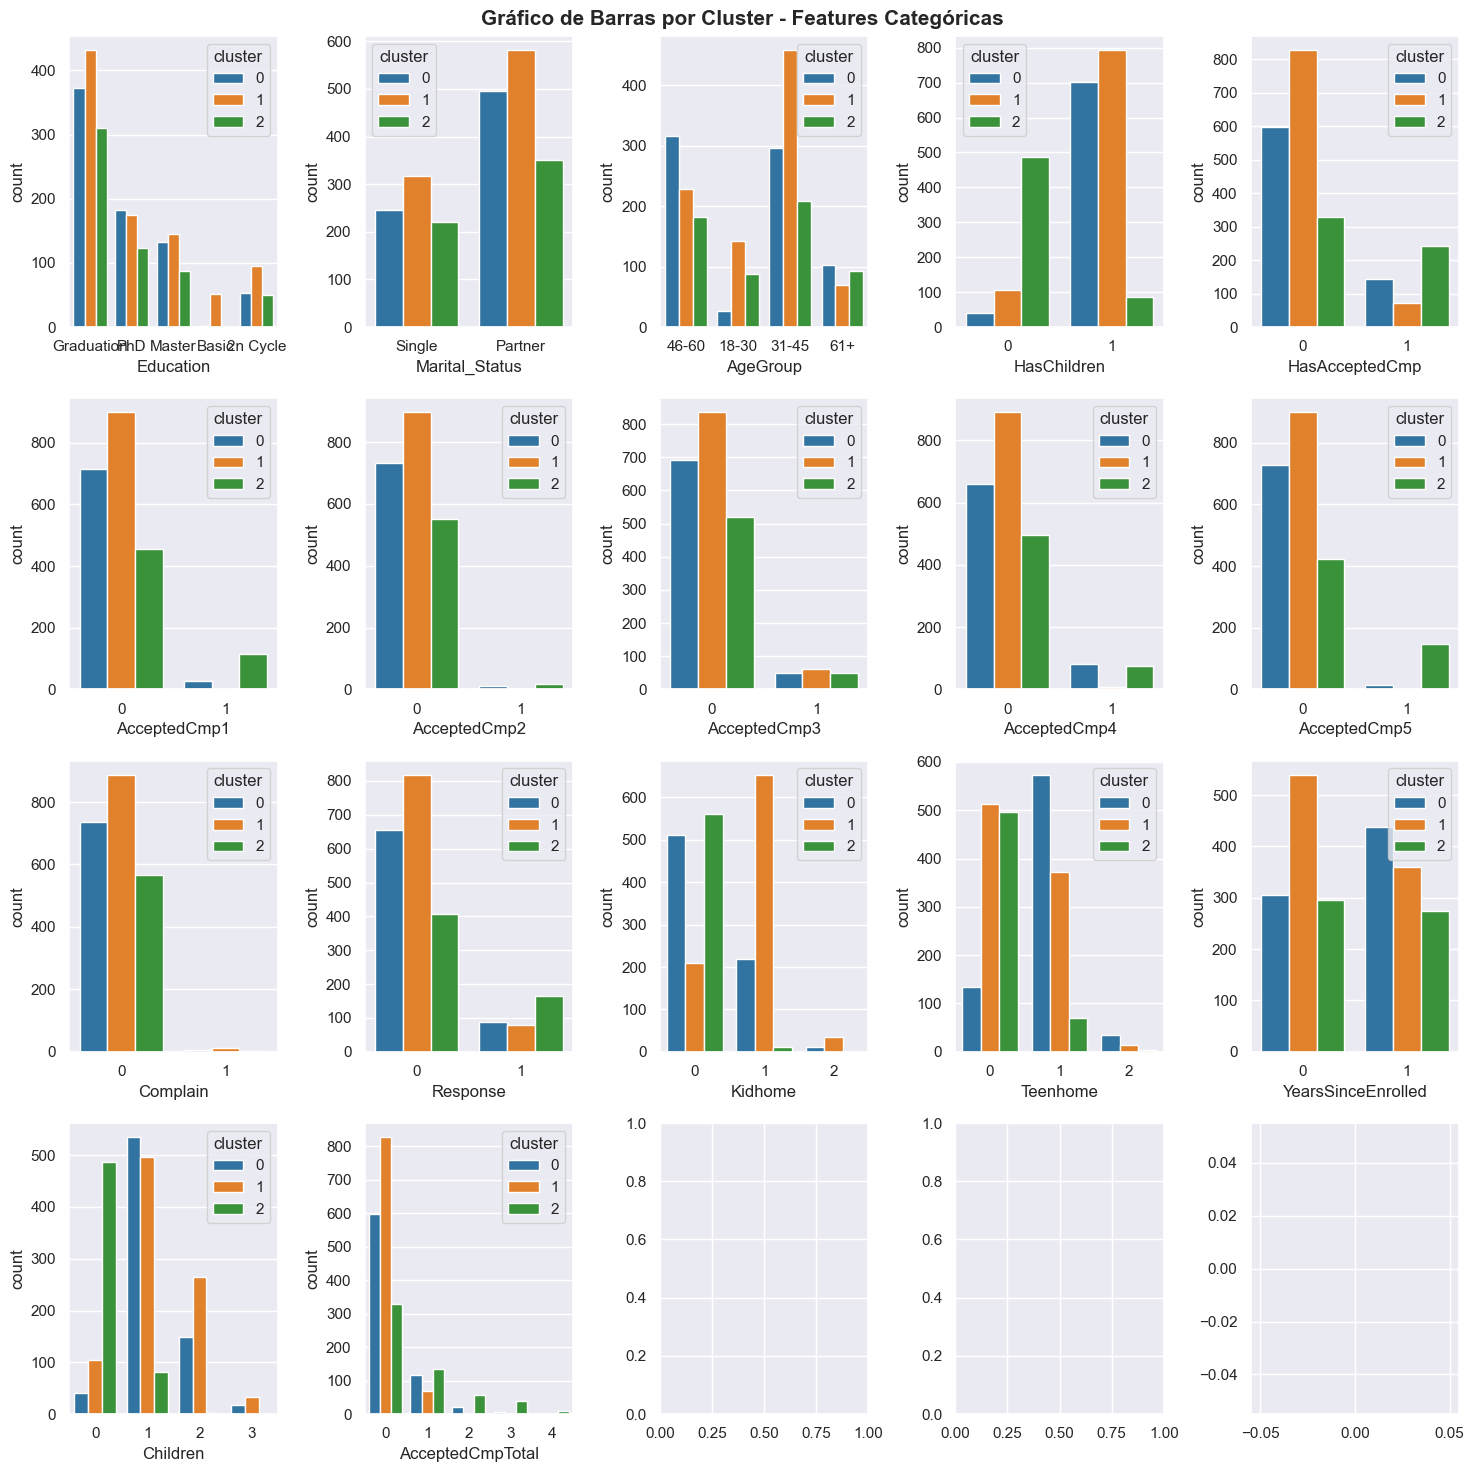

In [32]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(15,15))

for ax, coluna in zip(axs.flatten(), df_clustered[colunas_one_hot]):
    sns.countplot(
        data=df_clustered, 
        x=coluna, 
        ax=ax,
        hue='cluster',
        palette='tab10'
    )

fig.suptitle('Gráfico de Barras por Cluster - Features Categóricas', fontsize=15, fontweight='bold',)
plt.tight_layout()

plt.plot()  

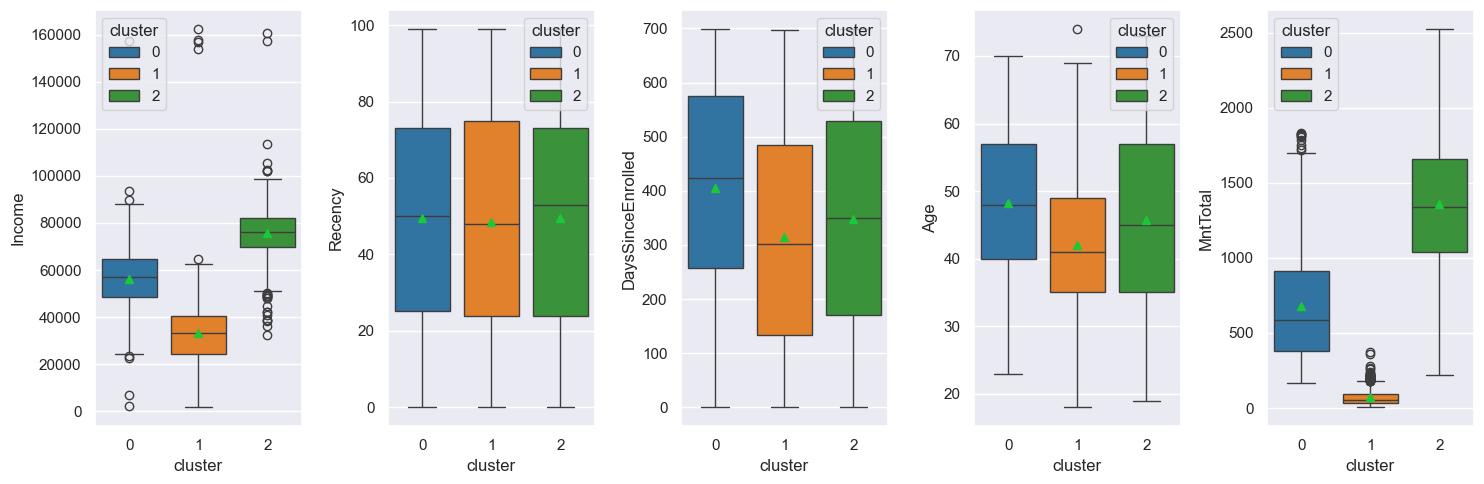

In [33]:
analise_colunas = ['Income', 'Recency', 'DaysSinceEnrolled', 'Age', 'MntTotal']

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5), tight_layout=True)

for ax, col in zip(axs, analise_colunas):
    sns.boxplot(x='cluster', y=col, data=df_clustered, ax=ax, showmeans=True, hue='cluster', palette='tab10')

**Análise**:
- Podemos ver que o cluster 1 é o que tem menor renda e o que gasta menos
- Já o cluster 2 é quem tem maior renda e gasta mais.
- Parece que a renda e o valor gasto nos produtos foram os principais critérios para a clusterização.

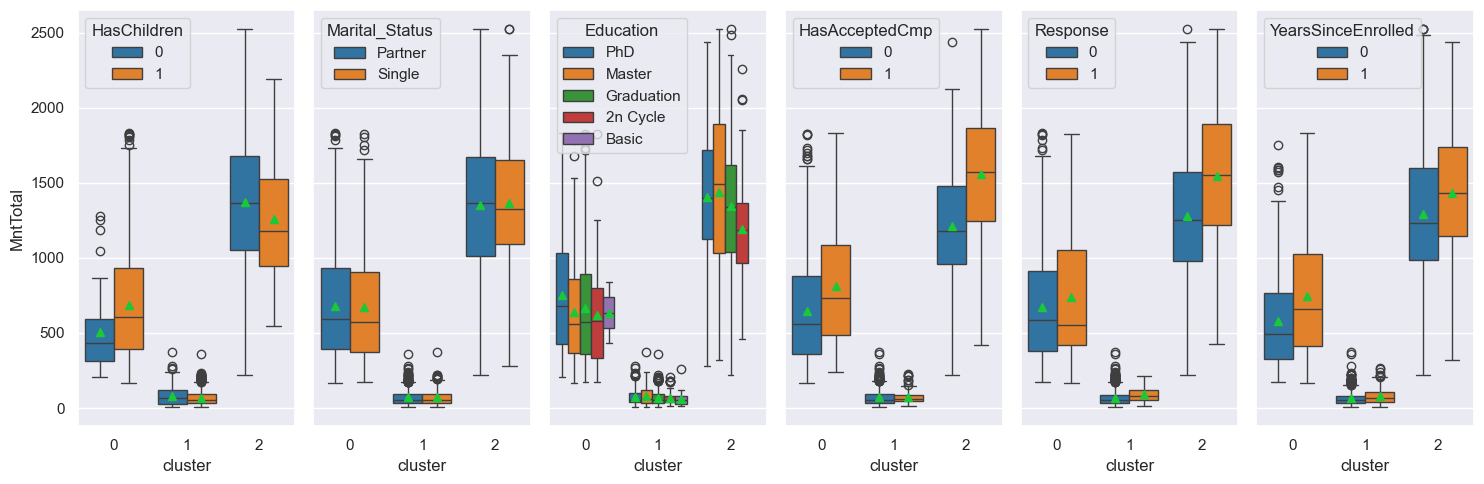

In [34]:
# Boxplot confrontando os clusters com as colunas de interesse e a feature MntTotal

analise_colunas = ['HasChildren', 'Marital_Status', 'Education','HasAcceptedCmp','Response','YearsSinceEnrolled']

clusters_diff_cols = ['MntTotal', 'Income']

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15, 5), tight_layout=True, sharey=True)

for ax, coluna in zip(axs, analise_colunas):
    sns.boxplot(x='cluster', y=clusters_diff_cols[0], data=df_clustered, ax=ax, showmeans=True, hue=coluna, palette='tab10')

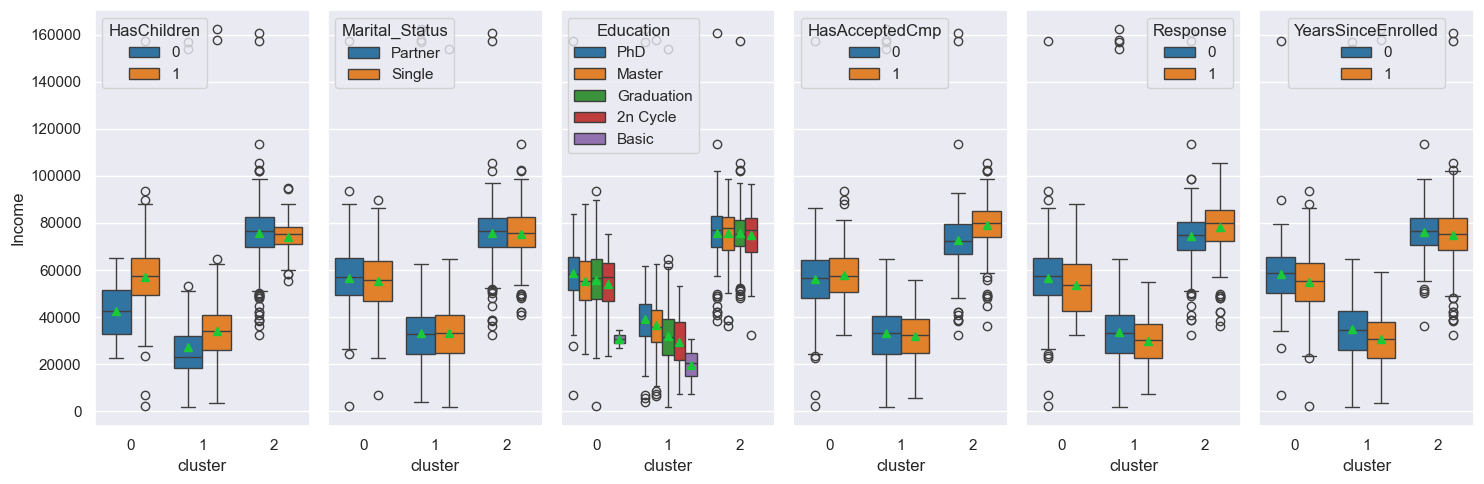

In [35]:
# Boxplot confrontando os clusters com as colunas de interesse e a feature Income

analise_colunas = ['HasChildren', 'Marital_Status', 'Education','HasAcceptedCmp','Response','YearsSinceEnrolled']

clusters_diff_cols = ['MntTotal', 'Income']

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15, 5), tight_layout=True, sharey=True)

for ax, coluna in zip(axs, analise_colunas):
    sns.boxplot(x='cluster', y=clusters_diff_cols[1], data=df_clustered, ax=ax, showmeans=True, hue=coluna, palette='tab10')

**Análise dos 2 gráficos acima**:
- Clientes que tem filhos tendem a gastar mais e ter maior renda quando pertecentes ao cluster 0, mas em relação ao cluster 2 isso se inverte
- MaritalStatus não gera efeitos significativos dentro de cada cluster em relação à gasto e renda.
- Dentro do cluster 2, quem tem maiores níveis educacionais tende a gastar mais, no entanto, a mesma regra não se traduz em maior renda. 
- Clientes que compraram após campanhas de marketing anteriores tendem a gastar mais e ter maior renda principalmente aqueles classificados dentro do cluster 2. Para o cluster 1 isso não tem diferença, e para o cluster 0 a renda é similar mas os gastos são maiores.
- Clientes que tiveram resposta positiva pra campanha piloto tendem a comprar e ter maior perfil de renda quando pertencentes ao cluster 2.
- Clientes cadastrados a mais tempo também gastaram mais, mas a renda apresenta pouca variação se o cliente foi cadastrado a mais de 1 ano ou não.

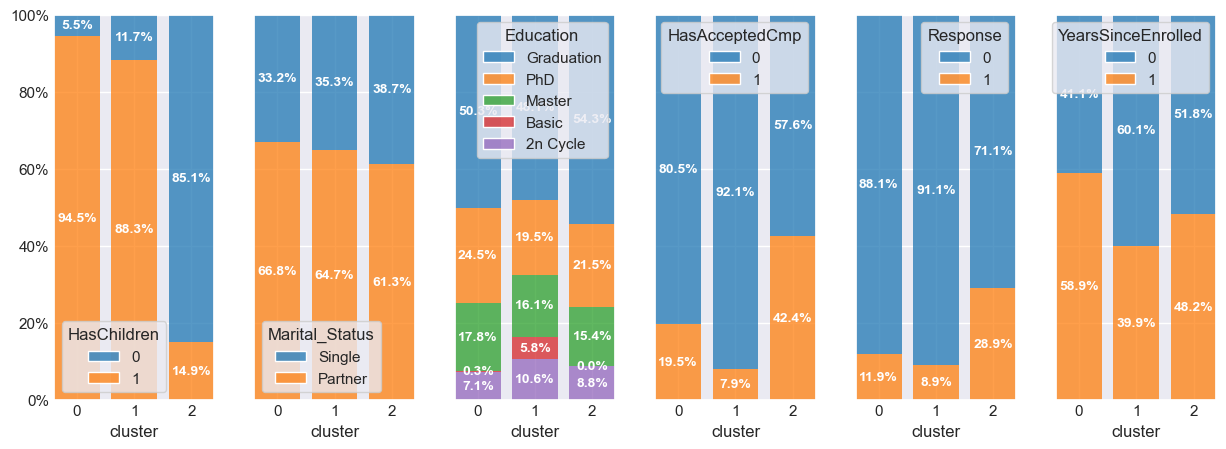

In [36]:
from src.graficos import plot_columns_percent_by_cluster

columns = ['HasChildren', 'Marital_Status', 'Education','HasAcceptedCmp','Response','YearsSinceEnrolled']

plot_columns_percent_by_cluster(df_clustered, columns=columns, column_cluster='cluster', figsize=(15, 5), rows_cols=(1, 6))

**Análise do gráficos acima**:
- Podemos ver que a grande maioria dos clientes do cluster 2 não tem filho, já no cluster 0 e 1 isso é o contrário
- Percentual de solteiros segue percentuais parecidos em cada cluster
- Cluster 2 possui um percentual de clientes muito maior que comprou após alguma campanha de marketing comparado ao cluster 0 e 1, e isso se repete na campanha piloto.

#### Podemos inverter as informações dos gráficos acima

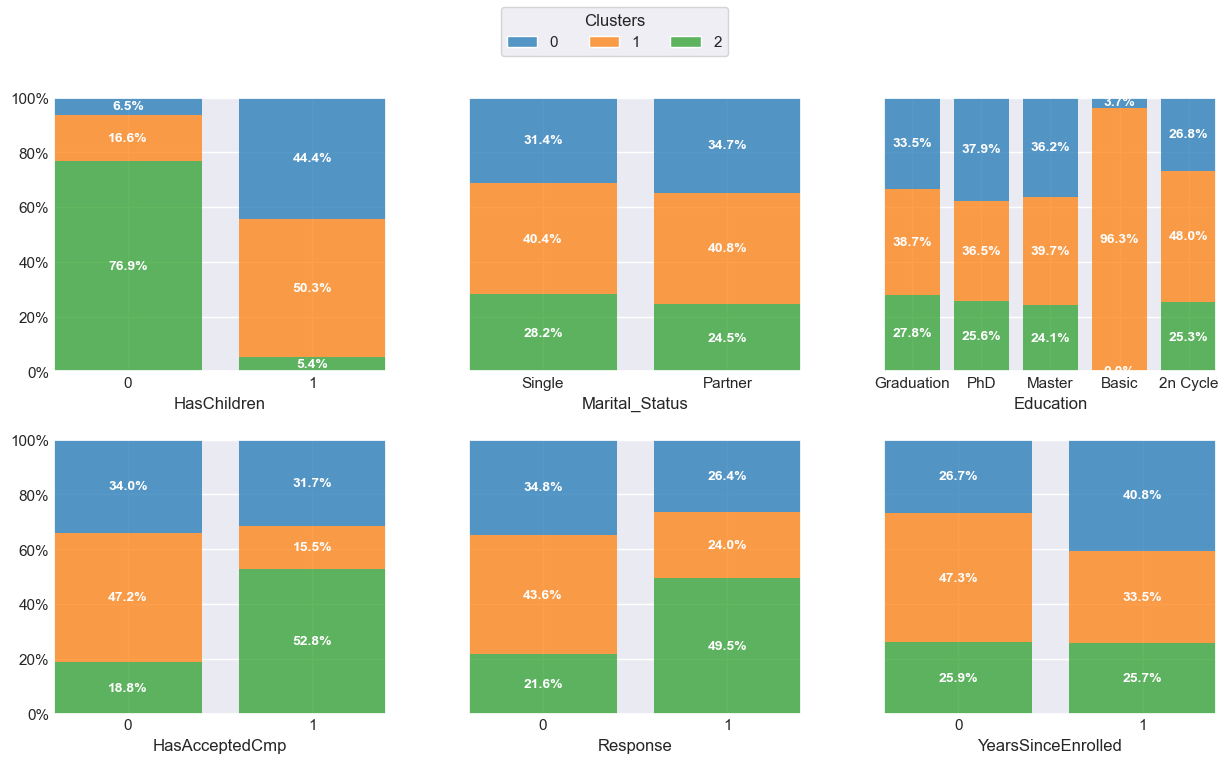

In [37]:
from src.graficos import plot_columns_percent_hue_cluster

plot_columns_percent_hue_cluster(
    dataframe=df_clustered,
    columns=['HasChildren', 'Marital_Status', 'Education','HasAcceptedCmp','Response','YearsSinceEnrolled'],
    column_cluster='cluster',
    rows_cols=(2, 3),
    figsize=(15, 8),
    palette='tab10'
)

**Análise do Gráfico Acima**:
- Cluster 2 é das pessoas que não tem filho na sua maioria
- Estado civil pouco influencia os clusters
- Quem tem ensino básico ta no cluster 1 e nehuma no cluster 2
- Pessoas do cluster 2 converteram mais nas campanhas de markting anteriores, e isso se repete na campanha piloto.

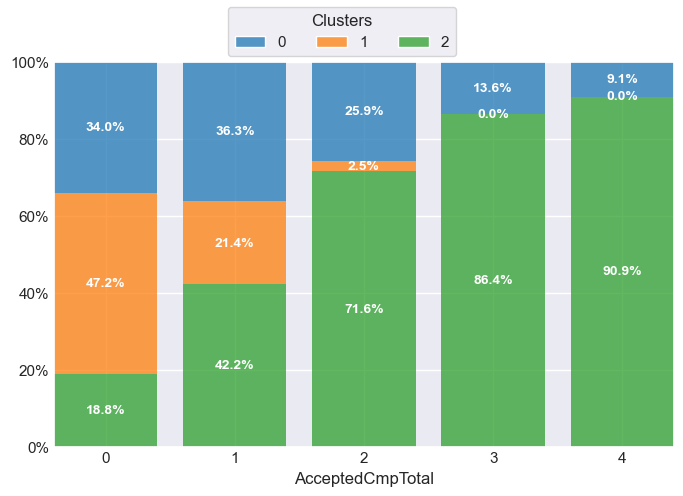

In [44]:
b = plot_columns_percent_hue_cluster(
    dataframe=df_clustered,
    columns=['AcceptedCmpTotal'],
    rows_cols=(1, 1),
    figsize=(8, 5),
    palette='tab10'
)

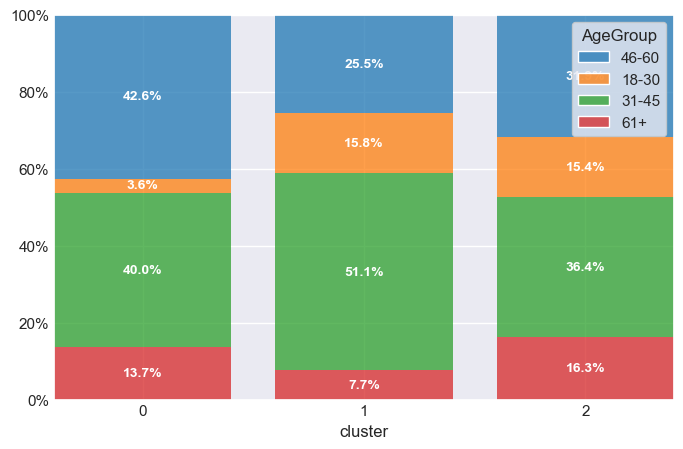

In [45]:
plot_columns_percent_by_cluster(
    dataframe=df_clustered,
    columns=['AgeGroup'],
    rows_cols=(1, 1),
    figsize=(8, 5),
    #palette='tab10'
)

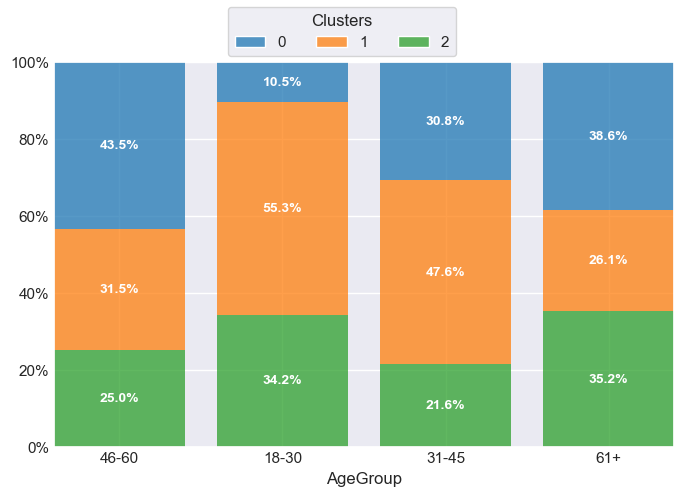

In [46]:
plot_columns_percent_hue_cluster(
    dataframe=df_clustered,
    columns=['AgeGroup'],
    rows_cols=(1, 1),
    figsize=(8, 5),
    palette='tab10'
)

In [47]:
df_clustered.groupby('cluster')[['Response']].mean()

,Response
cluster,
0,0.118598
1,0.088988
2,0.288967


In [48]:
df_clustered.groupby('cluster')[['Income']].mean()

,Income
cluster,
0,56357.268194
1,33279.741935
2,75652.028021


In [49]:
df_clustered.groupby('cluster')[['MntTotal']].mean()

,MntTotal
cluster,
0,678.830189
1,71.337041
2,1358.061296


In [56]:
# Taxa média de respostas da campanha piloto por cluster e Marital Status

pd.pivot_table(
    data=df_clustered,
    values='Response',
    index=['Marital_Status'],
    columns='cluster',
    aggfunc='mean',
    margins=True,
    margins_name='Média'
)

# OBS: Podemos ver que pessoas sozinhas são as que mais tiveram taxa de resposta na campanha piloto, e que casados e juntos tiveram a menor taxa de resposta

cluster,0,1,2,Média
Marital_Status,,,,
Partner,0.098790,0.067010,0.200000,0.110644
Single,0.158537,0.129338,0.429864,0.223214
Média,0.118598,0.088988,0.288967,0.150542


In [57]:
# Taxa média de respostas da campanha piloto por cluster e Marital Status

pd.pivot_table(
    data=df_clustered,
    values='Response',
    index=['Education'],
    columns='cluster',
    aggfunc='mean',
    margins=True,
    margins_name='Média'
)

# OBS: Podemos ver que pessoas com maior grau de escolaridade (Mestrado e Doutorado) são as que mais tiveram taxa de resposta na campanha piloto

cluster,0,1,2,Média
Education,,,,
2n Cycle,0.037736,0.084211,0.240000,0.111111
Basic,0.000000,0.038462,NaN,0.037037
Graduation,0.099196,0.081019,0.258065,0.136323
Master,0.106061,0.117241,0.284091,0.153425
PhD,0.192308,0.102857,0.390244,0.210417
Média,0.118598,0.088988,0.288967,0.150542


##### OBS: Cuidar que correlação não é causalidade

### **Definição dos Clusters**

- **Cluster 2**: Tem maior e renda e padrão de gasto de todos os produtos; Não possuem crianças e/ou adolescentes em casa; Tiveram maior taxa de resposta da campanha piloto 
- **Cluster 1**: Aqueles que tem baixa renda e baixo padrão de gasto com todos os produtos; Geralmente possuem crianças em casa; Tiveram a menor taxa de resposta da campanha piloto
- **Cluster 0**: Renda e padrão de gasto mediano, geralmente possuem filhos em casa, e a propensão de compra após campanhas de marketing ainda é baixa.

A maioria dos clientes de cada cluster tem perfil conforme a tabela abaixo:

| Renda   | Padrão de Gasto / Consumo| Filhos em casa?  | Propensão à comprar após campanhas de marketing | % Resposta Campanha Piloto | Cluster |
|---------|--------------------------|------------------|-----------------------|----------------------------|---------|
| Alta    | Alto                     | Provavelmente Não| Um pouco maior                   |    28%                     | 2       |
| Baixa   | Baixo                    | Provavelmente Sim| Geralmente não |    8.8%                    | 1       |
| Mediana | Mediano (variando)       | Provavelmente Sim| Menor       |    11.8%                     | 0       |

**Para qual cliente deve ser direcionado a 6ª campanha de marketing?**
- Nesse caso, mesmo que ainda não seja definido um modelo de classificação para determinar quais clientes devem receber as campanhas de marketing, é sugerido que essa campanha seja direcionada aos clientes do cluster 2.